### TODO: ADD Title

### Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from scipy import stats

### Constants

In [41]:

K_LIST = [2, 4, 8]
STD_DEV_LIST = [.3, .5, .7]

CLASS_1 = 0
CLASS_2 = 1
COLOR_1 = 'blue'
COLOR_2 = 'yellos'

MEAN = 0
N_FOLDS = 4
GROUP_COUNT = 5
TEST_PROPORTION = .25

COORD_MIN = -5
COORD_MAX = 5

## Generate samples

In [34]:
def getNewGroupSamples(gaussian: stats.norm, gCount: int, xOffset: int, yOffset: int) -> tuple:
    _x = xOffset + gaussian.rvs(size=gCount)
    _y = yOffset + gaussian.rvs(size=gCount)
    return _x, _y

def getGroupFromDF(df: pd.DataFrame, cNumber: int, gNumber: int) -> np.array:
    return df[ (df['class'] == cNumber) & (df['group'] == gNumber)][ ['x', 'y'] ].values

def getSampleDF(
    mean: float, stdDeviation: float,
    itemsPerGroup: int
) -> pd.DataFrame:

    gaussian = stats.norm(loc=mean, scale=stdDeviation)
    samples = np.zeros( (4 * itemsPerGroup, 4) )

    # Class 01 / group 01
    x11, y11 = getNewGroupSamples(gaussian=gaussian, gCount=itemsPerGroup, xOffset=COORD_MIN, yOffset=COORD_MIN)
    samples[:itemsPerGroup, 0] = x11
    samples[:itemsPerGroup, 1] = y11
    samples[:itemsPerGroup, 2] = CLASS_1
    samples[:itemsPerGroup, 3] = 1

    # Class 01 / group 02
    x12, y12 = getNewGroupSamples(gaussian=gaussian, gCount=itemsPerGroup, xOffset=COORD_MAX, yOffset=COORD_MAX)
    samples[itemsPerGroup : 2*itemsPerGroup, 0] = x12
    samples[itemsPerGroup : 2*itemsPerGroup, 1] = y12
    samples[itemsPerGroup : 2*itemsPerGroup, 2] = CLASS_1
    samples[itemsPerGroup : 2*itemsPerGroup, 3] = 2

    # Class 02 / group 01
    x21, y21 = getNewGroupSamples(gaussian=gaussian, gCount=itemsPerGroup, xOffset=COORD_MIN, yOffset=COORD_MAX)
    samples[2*itemsPerGroup : 3*itemsPerGroup, 0] = x21
    samples[2*itemsPerGroup : 3*itemsPerGroup, 1] = y21
    samples[2*itemsPerGroup : 3*itemsPerGroup, 2] = CLASS_2
    samples[2*itemsPerGroup : 3*itemsPerGroup, 3] = 1

    # Class 01 / group 02
    x22, y22 = getNewGroupSamples(gaussian=gaussian, gCount=itemsPerGroup, xOffset=COORD_MAX, yOffset=COORD_MIN)
    samples[3*itemsPerGroup : 4*itemsPerGroup, 0] = x22
    samples[3*itemsPerGroup : 4*itemsPerGroup, 1] = y22
    samples[3*itemsPerGroup : 4*itemsPerGroup, 2] = CLASS_2
    samples[3*itemsPerGroup : 4*itemsPerGroup, 3] = 2

    # Create dataframe
    return pd.DataFrame.from_records(data=samples, columns=['x', 'y', 'class', 'group'])


### Plot samples

In [29]:
def plotSamples(dataFrames: list, figsize = [12, 7]) -> None:
    plt.rcParams["figure.figsize"] = figsize

    for dfTuple in dataFrames:
        df, marker, color1, color2 = dfTuple

        aux = getGroupFromDF(df, CLASS_1, 1)
        x11 = aux[:, 0]
        y11 = aux[:, 1]

        aux = getGroupFromDF(df, CLASS_1, 2)
        x12 = aux[:, 0]
        y12 = aux[:, 1]

        aux = getGroupFromDF(df, CLASS_2, 1)
        x21 = aux[:, 0]
        y21 = aux[:, 1]

        aux = getGroupFromDF(df, CLASS_2, 2)
        x22 = aux[:, 0]
        y22 = aux[:, 1]

        plt.scatter(x11, y11, color=color1, marker=marker)
        plt.scatter(x12, y12, color=color1, marker=marker)
        plt.scatter(x21, y21, color=color2, marker=marker)
        plt.scatter(x22, y22, color=color2, marker=marker)

    plt.title('Sample')
    plt.show()

### KNN Classifier

In [36]:

def euclideanDistance(row1: np.array, row2: np.array) -> float:
	distance = 0.0
	for i in range(row2.shape[0] - 1):
		distance += (row1[i] - row2[i])**2
	return math.sqrt(distance)

def getCrossValidationFolds(df: pd.DataFrame, nFolds: int, proportion: float) -> list:

	rowsCount, colsCount = df.values.shape
	testSize = math.ceil(proportion * rowsCount)
	folds = np.zeros(nFolds, dtype=tuple)

	for i in range(0, nFolds):
		randomizedDF = df.iloc[np.random.permutation(rowsCount)].reset_index()
		testDF = randomizedDF.iloc[:testSize, :]
		trainDF = randomizedDF.iloc[testSize:, :]
		folds[i] = (testDF, trainDF)
	return folds

def getPredictions(trainDF: pd.DataFrame, testDF: pd.Series, k: int) -> np.array:
	trainSize = testDF.shape[0]
	predictions = np.zeros( (trainSize,) )
	for i in range(0, trainSize):
		predictions[i] = knn(trainDF, testDF.loc[i], k)
	return predictions

def knn(trainDF: pd.DataFrame, testDF: pd.Series, k: int) -> float:
	trainValues = testDF[ ['x', 'y'] ].values
	distancesDF = trainDF.copy()
	distancesDF['distance'] = trainDF.apply(lambda row: euclideanDistance(row[ ['x', 'y'] ].values, trainValues), axis=1)
	distancesDF = distancesDF.sort_values(by=['distance'], ascending=True, na_position='last')
	distancesDF = distancesDF.iloc[:k, :]['class']
	return distancesDF.mode().iloc[0]

## Test

['[0] stdDev: 0.3, k: 2 (fold 1) --=> Accuracy: 0.6666666666666666',
 '[0] stdDev: 0.3, k: 2 (fold 2) --=> Accuracy: 0.6666666666666666',
 '[0] stdDev: 0.3, k: 2 (fold 3) --=> Accuracy: 0.6666666666666666',
 '[0] stdDev: 0.3, k: 2 (fold 4) --=> Accuracy: 0.5',
 '** --- ** --- ** --------------------------------------- **',
 '[0] stdDev: 0.3, k: 4 (fold 1) --=> Accuracy: 1.0',
 '[0] stdDev: 0.3, k: 4 (fold 2) --=> Accuracy: 1.0',
 '[0] stdDev: 0.3, k: 4 (fold 3) --=> Accuracy: 0.8333333333333334',
 '[0] stdDev: 0.3, k: 4 (fold 4) --=> Accuracy: 1.0',
 '** --- ** --- ** --------------------------------------- **',
 '[0] stdDev: 0.3, k: 8 (fold 1) --=> Accuracy: 0.5',
 '[0] stdDev: 0.3, k: 8 (fold 2) --=> Accuracy: 0.8333333333333334',
 '[0] stdDev: 0.3, k: 8 (fold 3) --=> Accuracy: 0.6666666666666666',
 '[0] stdDev: 0.3, k: 8 (fold 4) --=> Accuracy: 1.0',
 '** --- ** --- ** --------------------------------------- **',
 '---------------------------------------------------------------',
 '

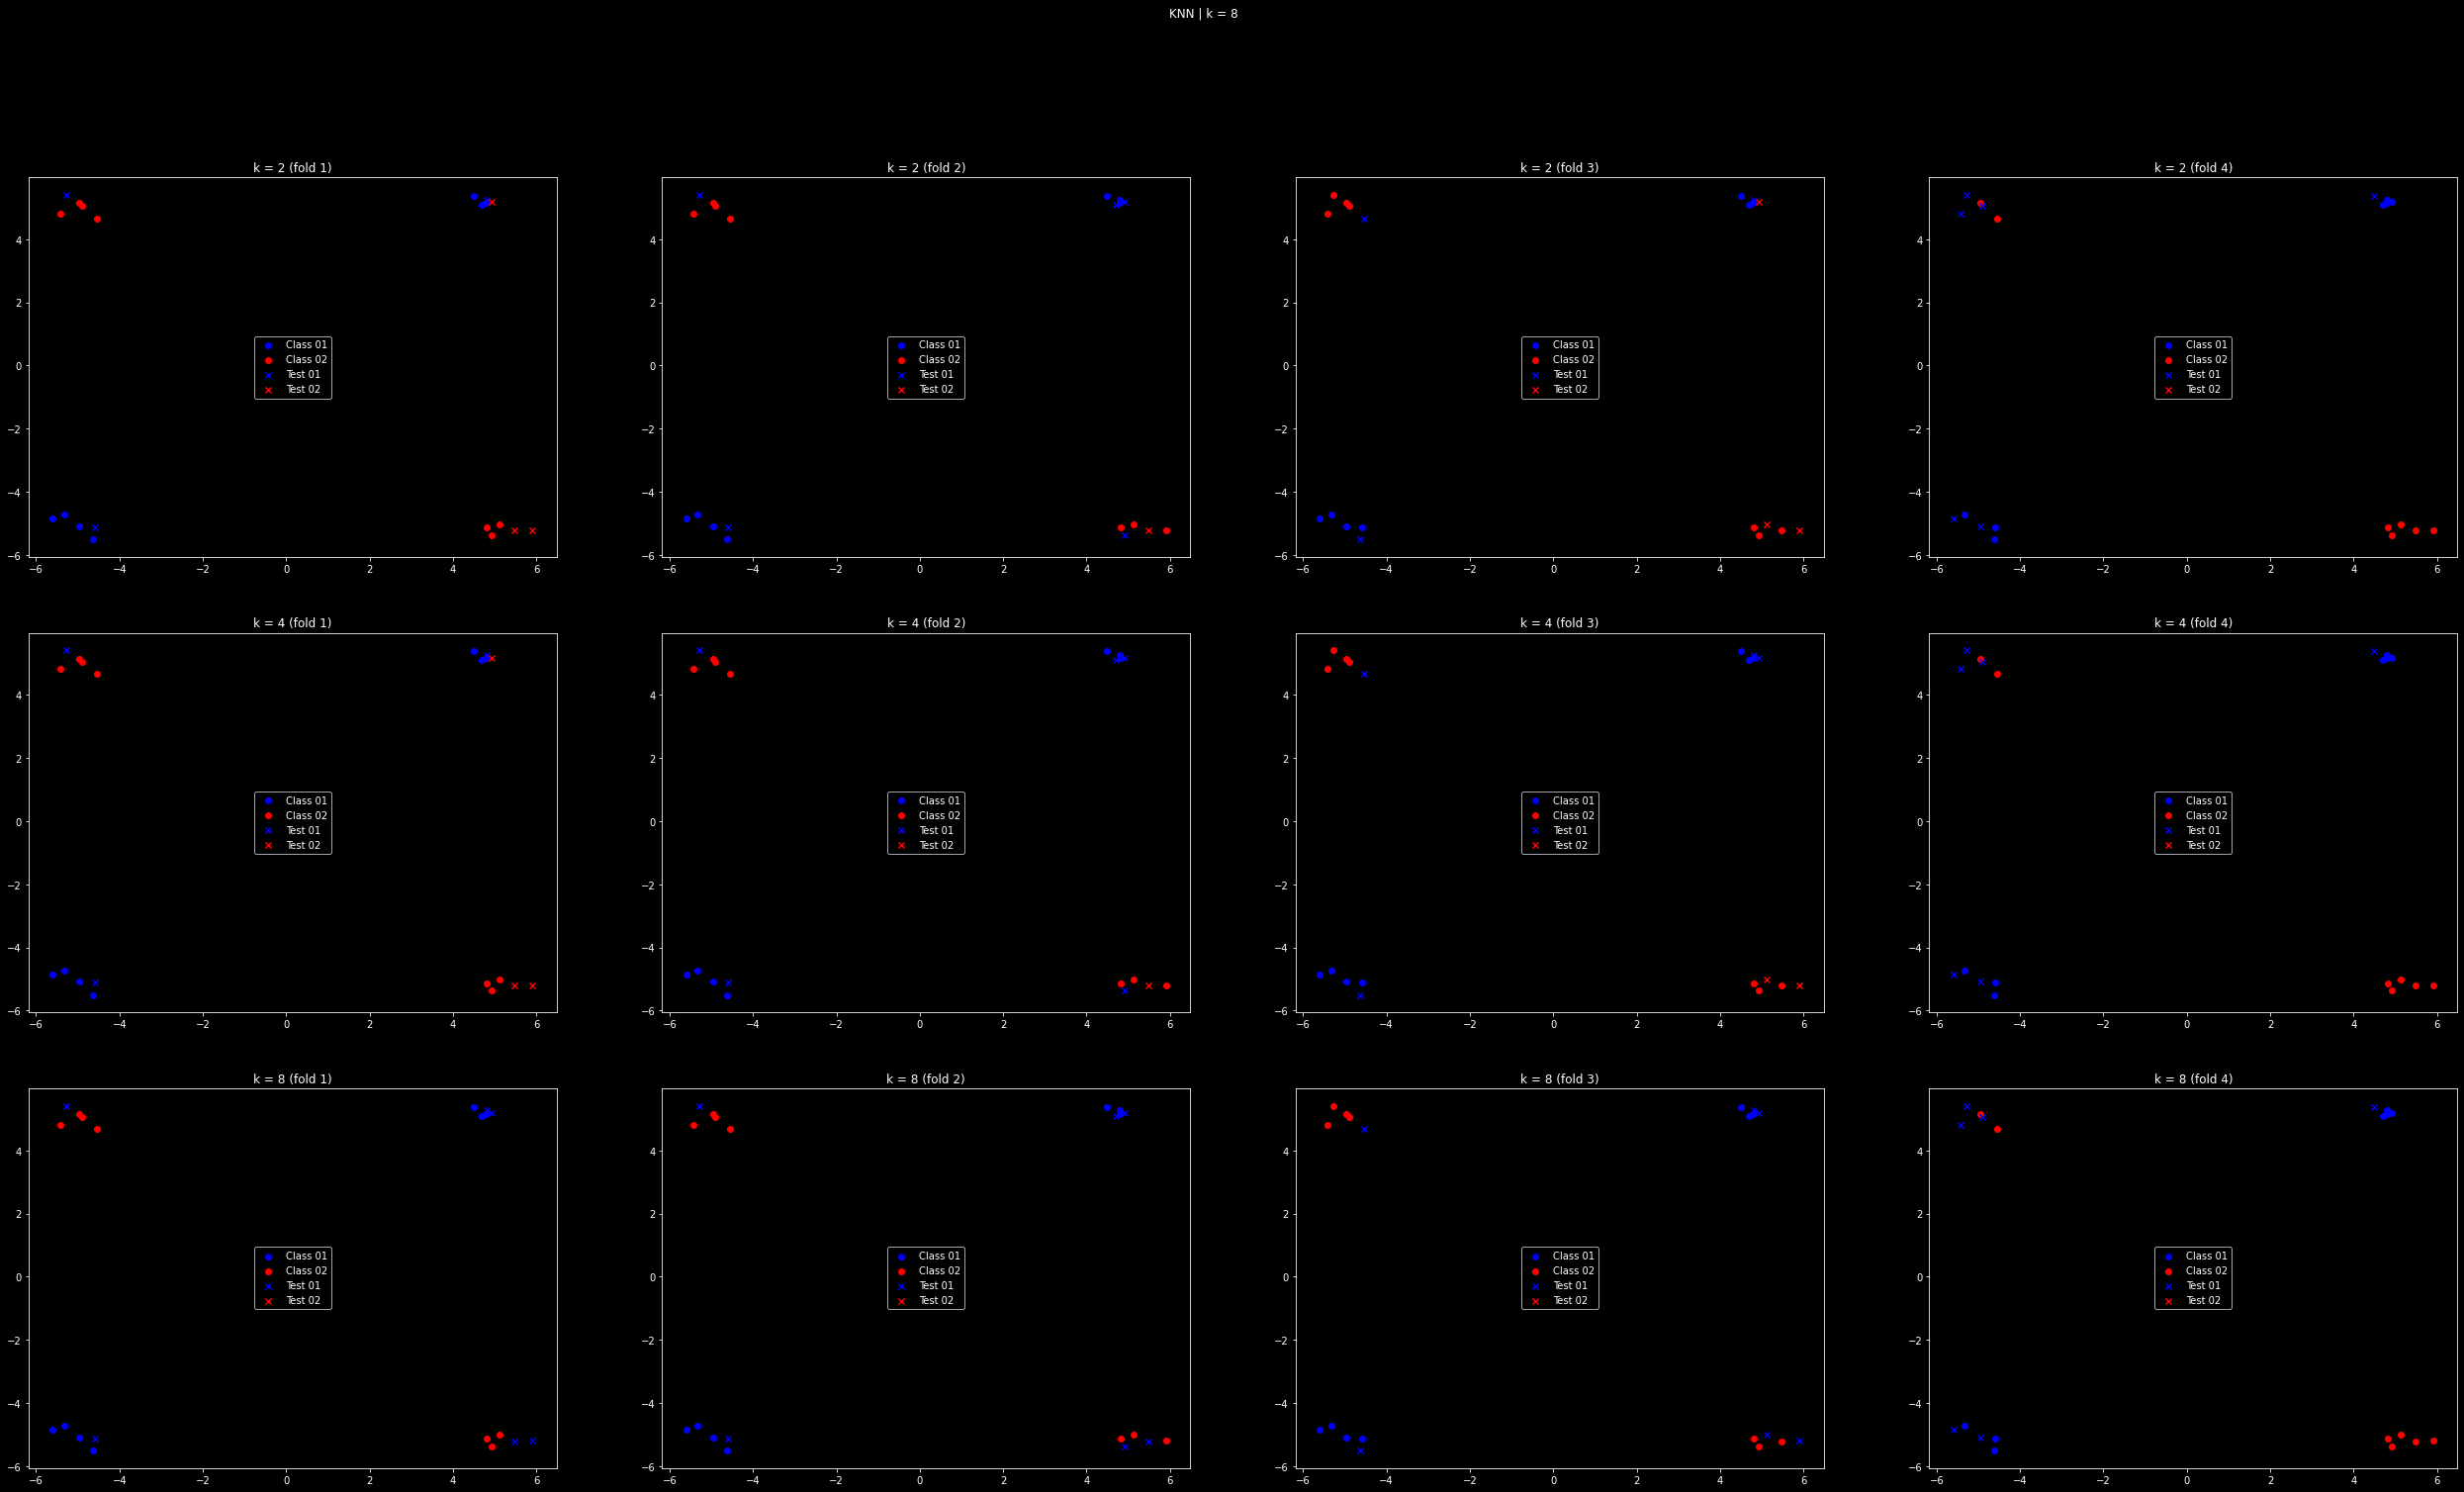

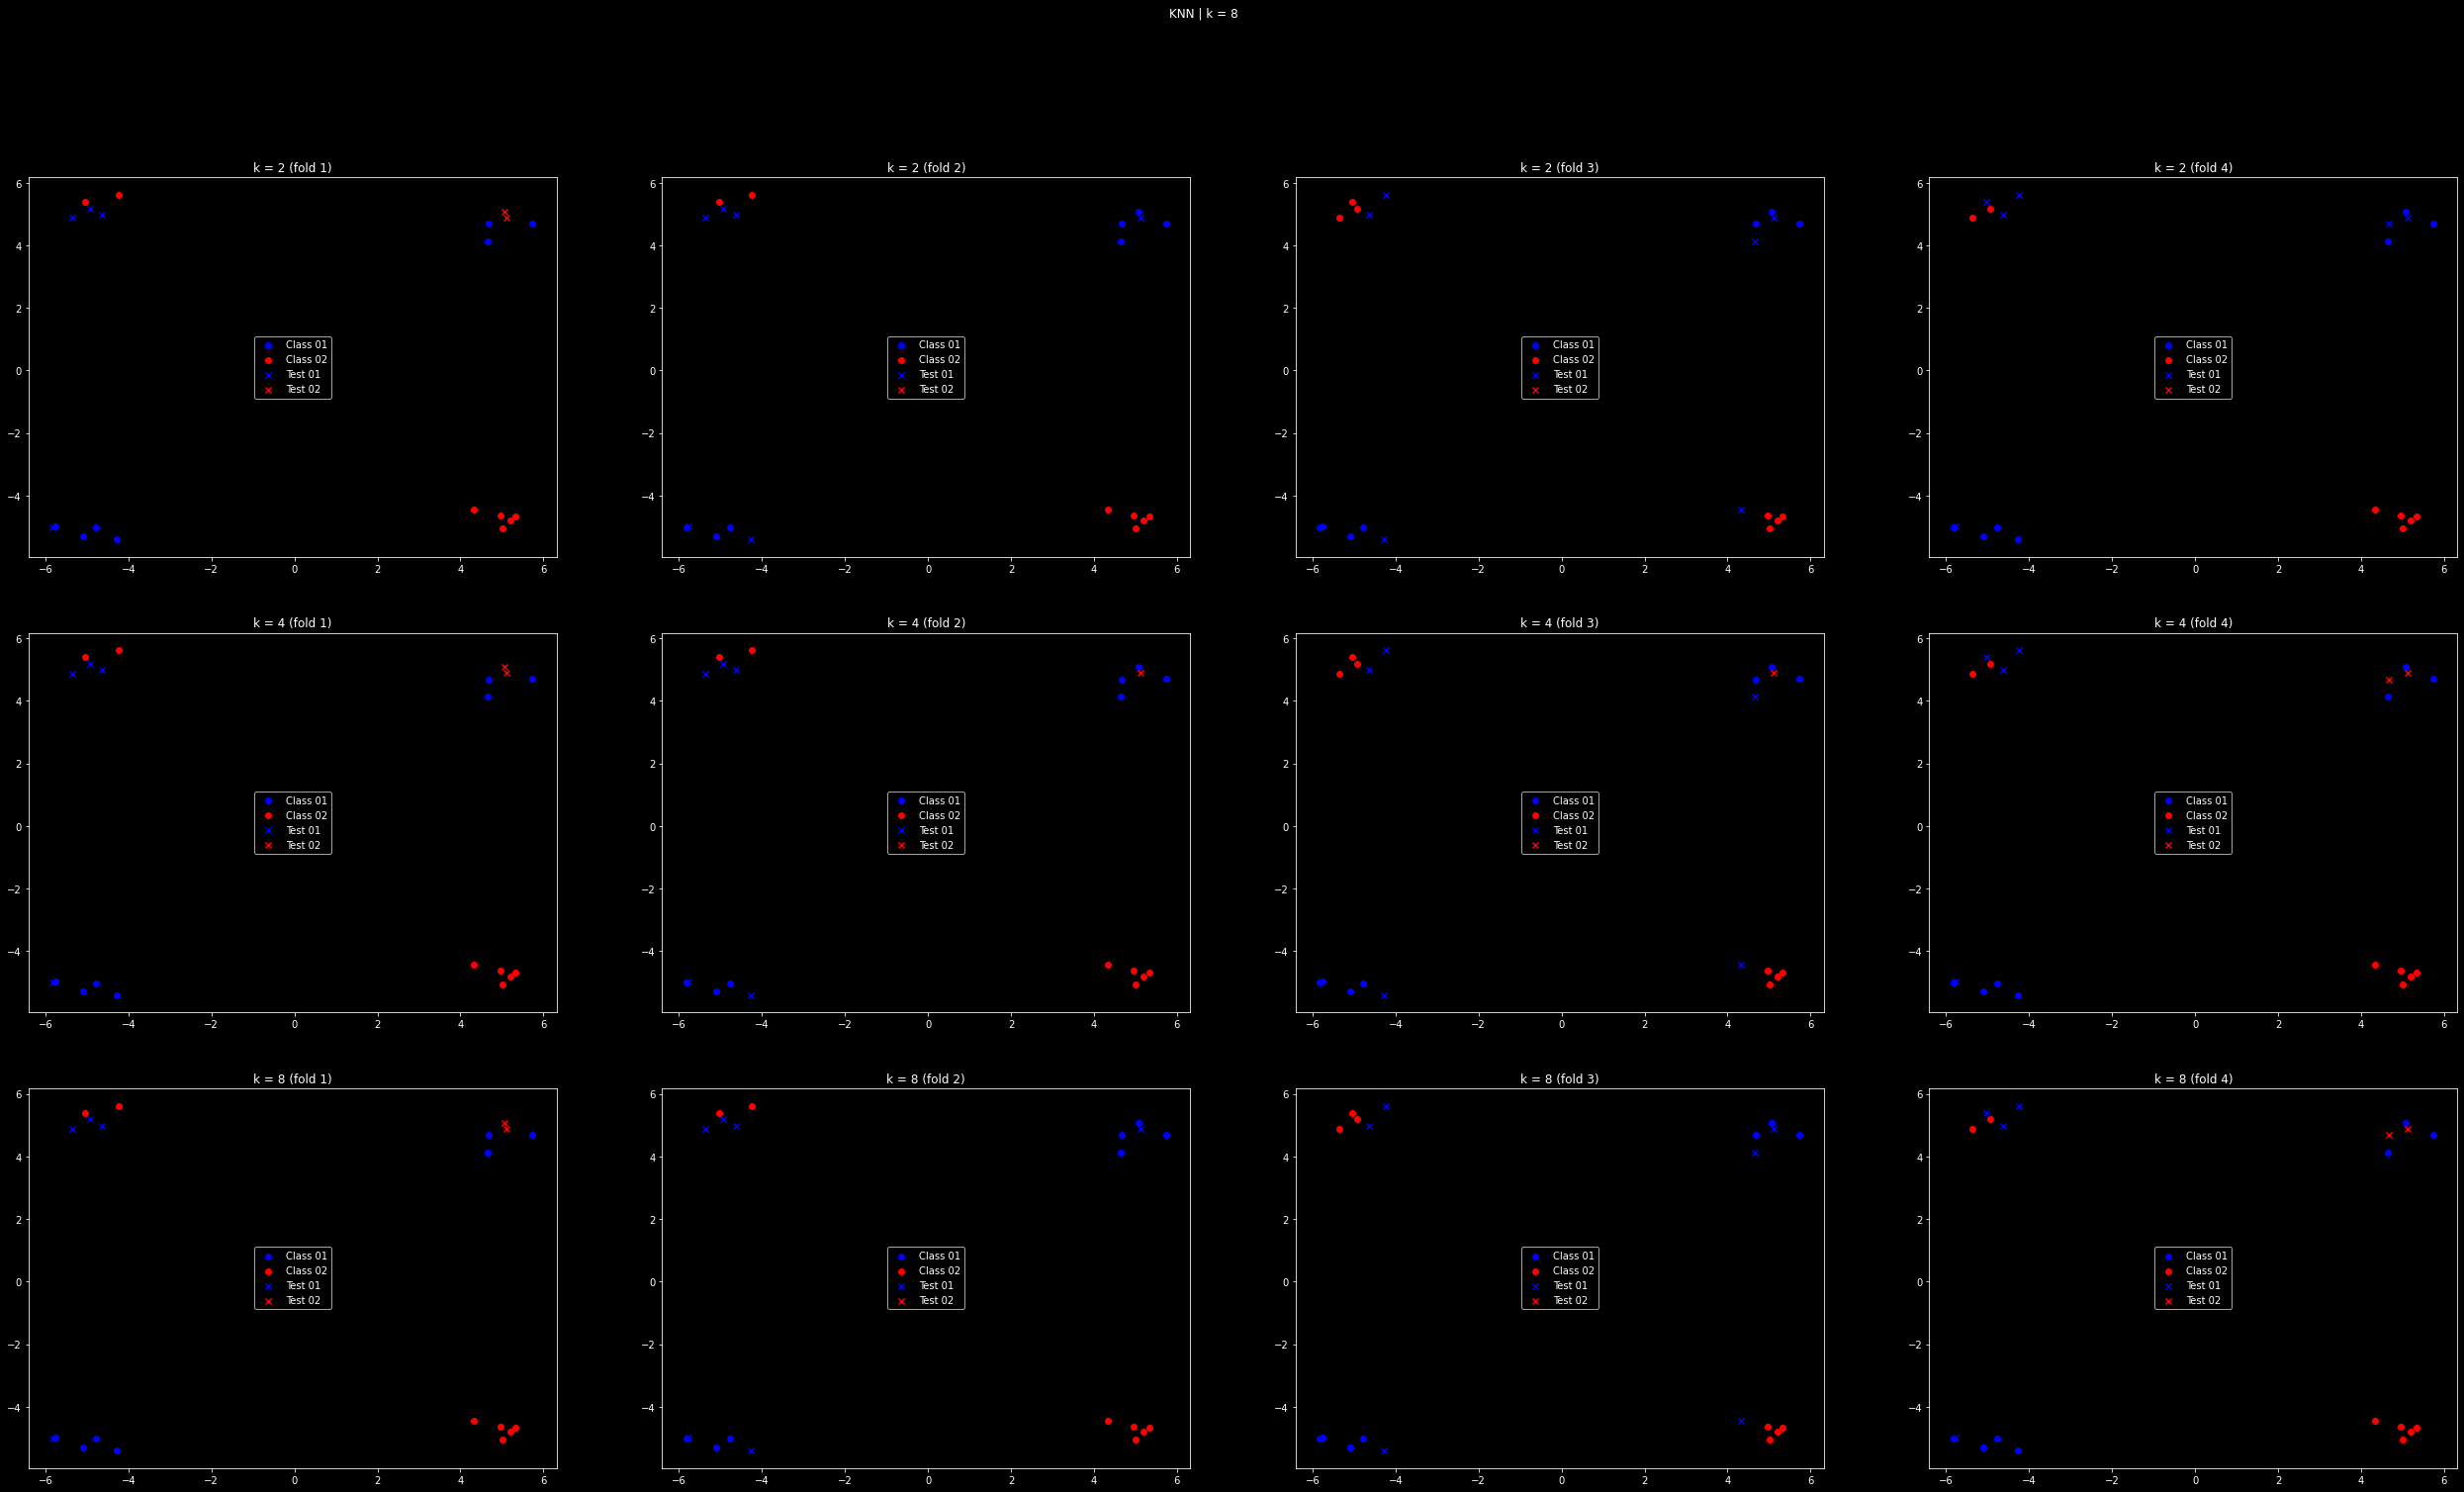

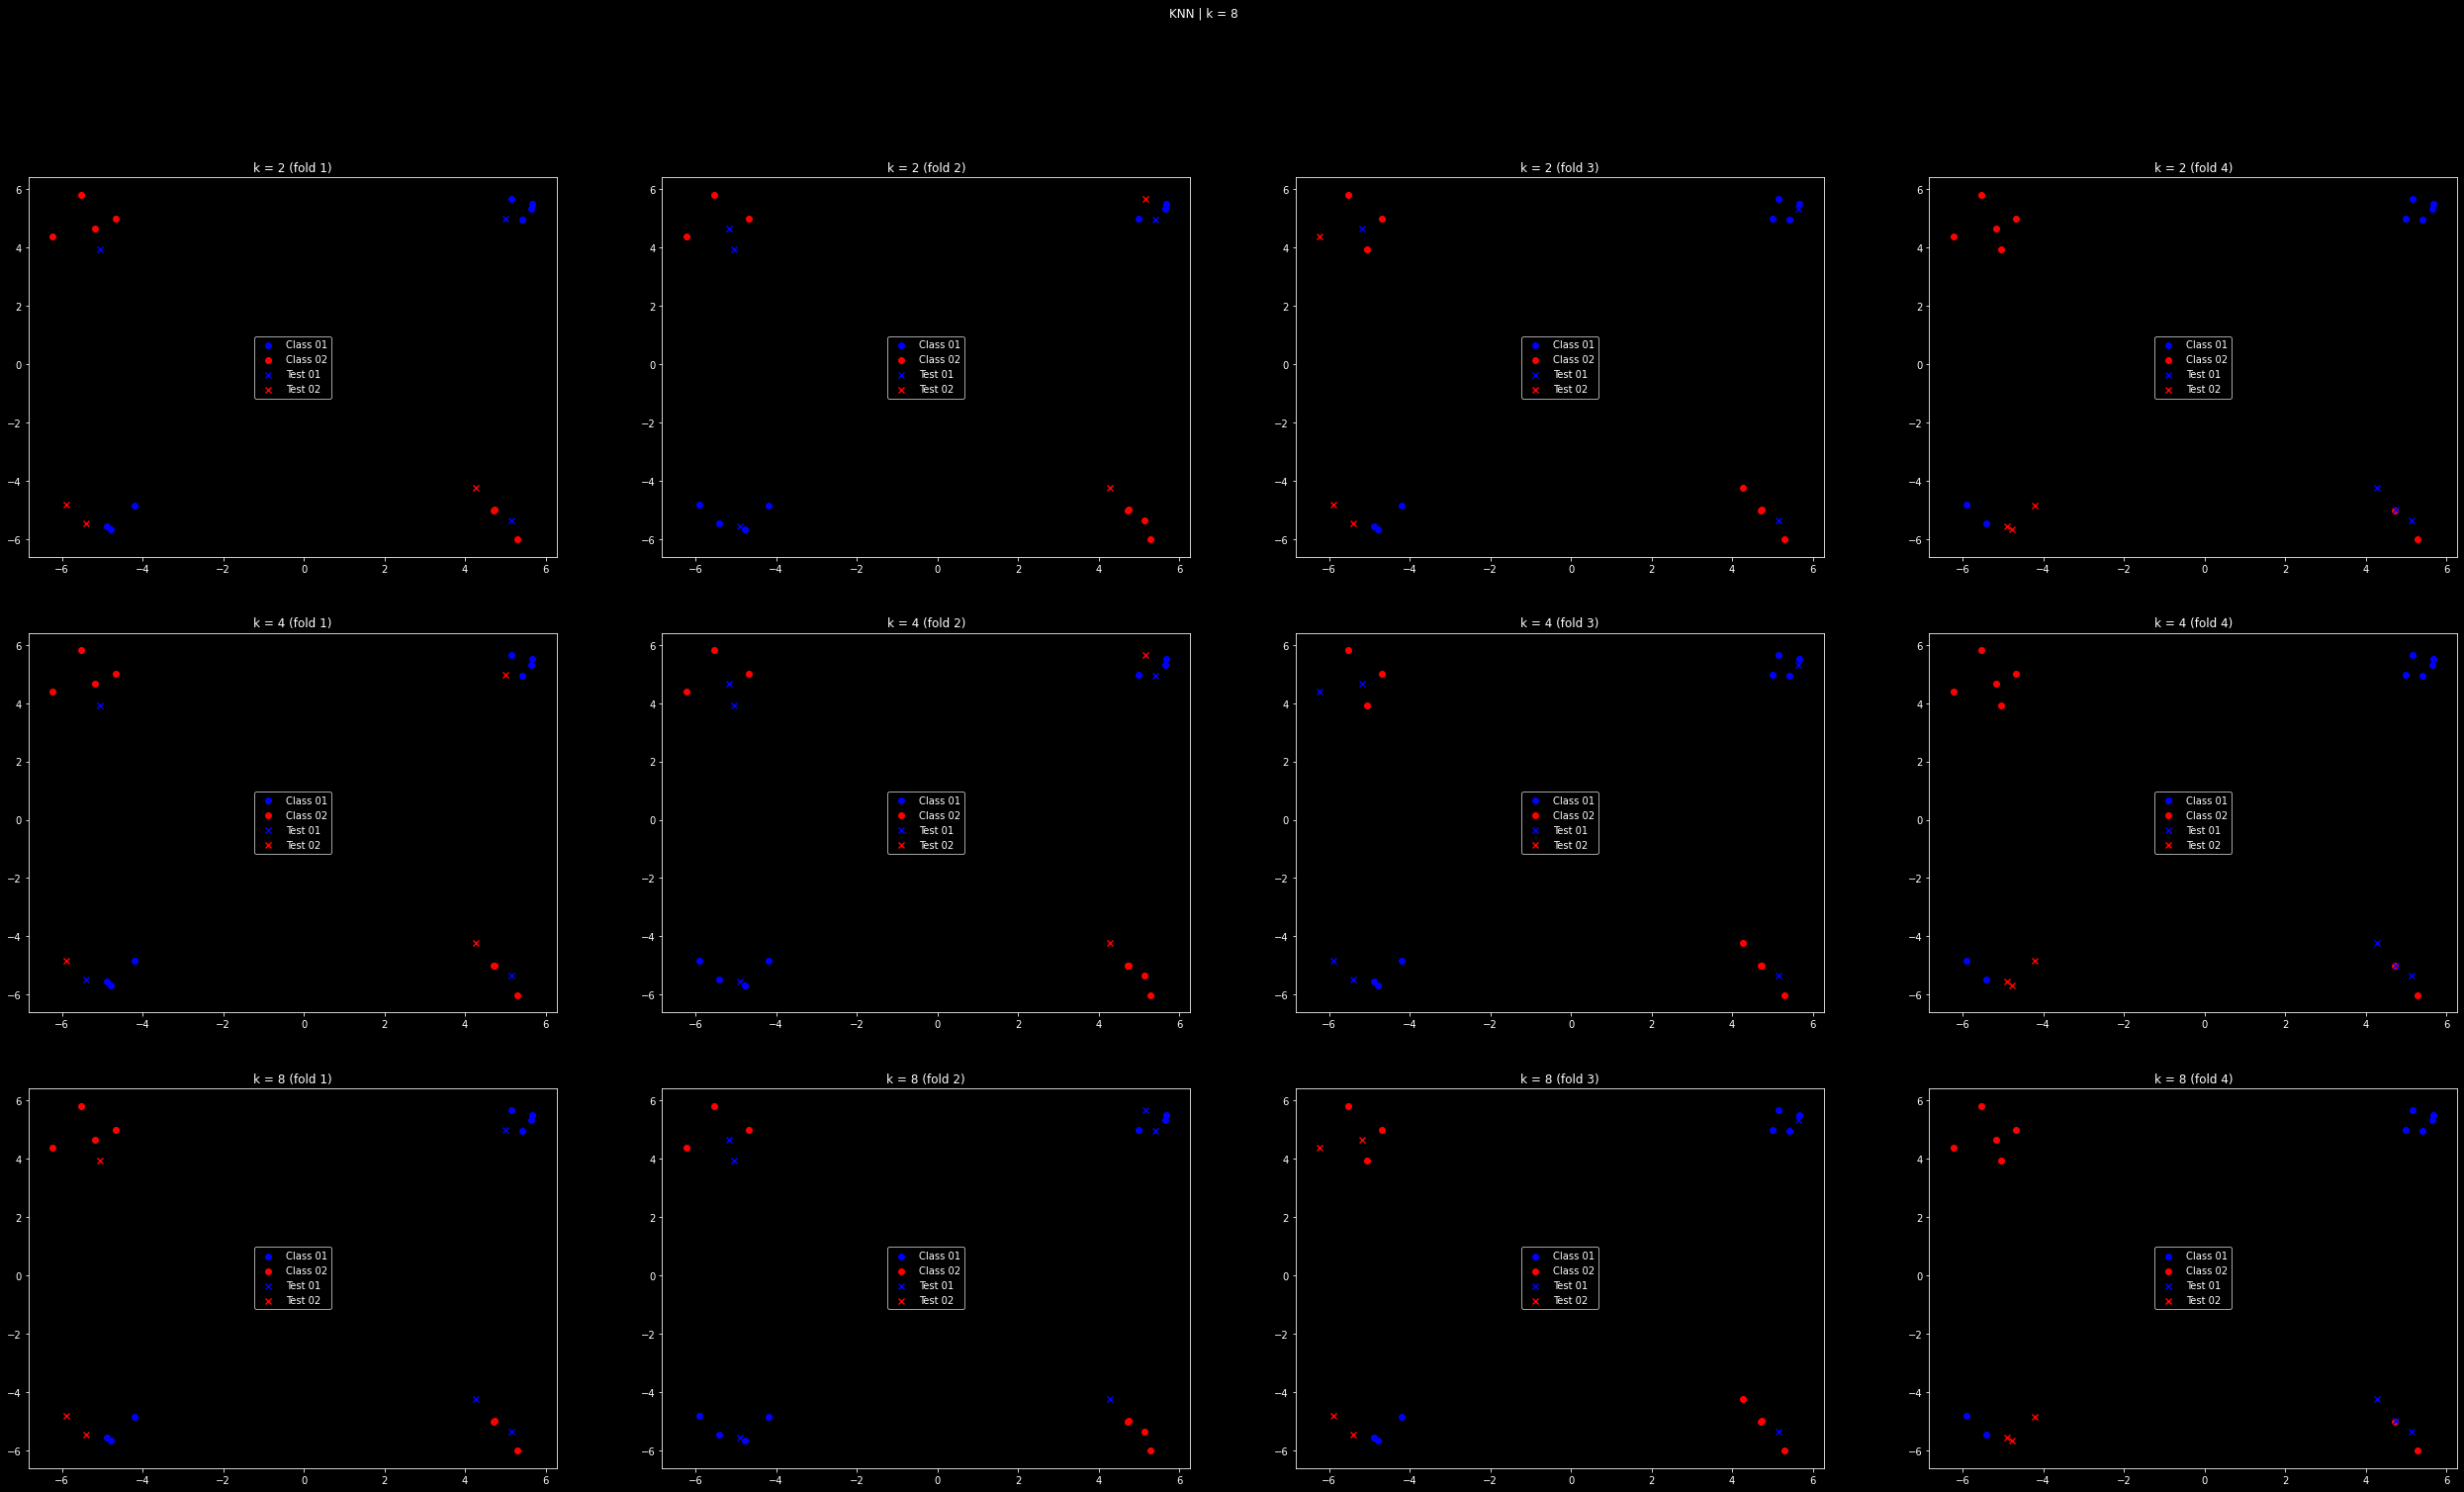

In [50]:

accuracies = []

colWidth = 8
colHeight = 11

nGraphs = len(STD_DEV_LIST)
nRows = len(K_LIST)
nCols = N_FOLDS

gridShape = (nRows, nCols)
legendLocation = 'center'

for i, stdDev in enumerate(STD_DEV_LIST):
    
    # Create grid
    figure = plt.figure(figsize=(colHeight*nCols, colWidth*nRows))
    figure.suptitle('KNN | (std Deviation = ' + str(stdDev))

    # Create data set
    df = getSampleDF(mean=MEAN, itemsPerGroup=GROUP_COUNT, stdDeviation=stdDev)
    c1DF = df.loc[ df['class'] == CLASS_1 ]
    c2DF = df.loc[ df['class'] == CLASS_2 ]
    foldsC1 = getCrossValidationFolds(nFolds=N_FOLDS, proportion=TEST_PROPORTION, df=c1DF)
    foldsC2 = getCrossValidationFolds(nFolds=N_FOLDS, proportion=TEST_PROPORTION, df=c2DF)

    for j, k in enumerate(K_LIST):
        figure.suptitle('KNN | k = ' + str(k))

        for f, fold1 in enumerate(foldsC1):
            fold2 = foldsC2[f]

            # Prepare one fold
            c1Test, c1Train = fold1
            c2Test, c2Train = fold2
            testDF = c1Test.append(c2Test).reset_index()
            trainDF = c1Train.append(c2Train).reset_index()

            # Run classification
            predictC1 = getPredictions(trainDF, c1Test, k)
            predictC2 = getPredictions(trainDF, c2Test, k)

            aux1 = c1Test['class'].values == predictC1
            aux2 = c2Test['class'].values == predictC2
            matchingCount = len(aux1[ aux1 == True ]) + len(aux2[ aux2 == True ])
            accuracy = matchingCount / (c1Test['class'].shape[0] + c2Test['class'].shape[0])

            # Parse classification
            c1Test['class'] = predictC1
            c2Test['class'] = predictC2
            plotDF = c1Test.append(c2Test)
            plotDF1 = plotDF[ plotDF['class'] == CLASS_1 ]
            plotDF2 = plotDF[ plotDF['class'] == CLASS_2 ]

            # Plot
            a = plt.subplot2grid(gridShape, (j, f), fig=figure)
            a.scatter(c1Train['x'].values, c1Train['y'].values, color='b', marker='o', label='Class 01')
            a.scatter(c2Train['x'].values, c2Train['y'].values, color='r', marker='o', label='Class 02')
            
            a.scatter(plotDF1['x'].values, plotDF1['y'].values, color='b', marker='x', label='Test 01')
            a.scatter(plotDF2['x'].values, plotDF2['y'].values, color='r', marker='x', label='Test 02')
            
            a.set_title('k = ' + str(k) + ' (fold ' + str(f + 1) + ')')
            a.legend(loc=legendLocation)
            
            # Measure
            msg = '[' + str(i) + '] stdDev: ' + str(stdDev) + ', k: ' + str(k) + ' (fold ' + str(f + 1) + ') --=> Accuracy: ' + str(accuracy)
            accuracies.append(msg)

        accuracies.append('** --- ** --- ** --------------------------------------- **')

    accuracies.append('---------------------------------------------------------------')

accuracies